# Importing libraries

In [1]:
import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd
import pycbc.filter
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform
import numpy as np
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr
import pandas as pd
from pycbc.filter import sigma

%matplotlib inline

# Generating noise

In [2]:
def gen_noise(psd_need):
    
    # The color of the noise matches a PSD which you provide
    flow = 30.0
    delta_f = 1.0 / 16
    flen = int(2048 / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

    if (psd_need == True) :
        pp.plot(psd.sample_frequencies,psd.data)
        pp.loglog()
        pp.xlim(30,2000)
        pp.ylabel('$Strain^2 / Hz$')
        pp.xlabel('Frequency (Hz)')
        pp.show()


    # Generate 512 seconds of noise at 4096 Hz
    delta_t = 1.0 / 4096
    tsamples = int(32/ delta_t)
    ts = pycbc.noise.gaussian.noise_from_psd(tsamples,delta_t, psd, seed=127)
    
    
    #plotting noise 
#     pp.plot(ts.sample_times, ts)
#     pp.ylabel('Strain')
#     pp.xlabel('Time (simport numpy as np

#     pp.show()
    

    return ts



# Generating strain

In [3]:
def gen_waveform(model,m1,m2,s1z,s2z,distance,time,l):
    
    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform


   
    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0




    # We can calcualate the antenna pattern for Hanford at
    # the specific sky location
    d = Detector("H1")

    # We get back the fp and fc antenna pattern weights.
    fp, fc = d.antenna_pattern(ra, dec, pol, time)
    #print("fp={}, fc={}".format(fp, fc))

    # These factors allow us to project a signal into what the detector would observe
    # IMRPhenomPv2
    # Generate the waveform for the BNS merger
    hp_1, hc_1 = get_td_waveform(approximant=model,
                             mass1=m1, mass2=m2,spin1z=s1z,spin2z=s2z,
                             distance=distance, inclination=inclination_1,
                             delta_t=1.0/4096, f_lower=30)

    ## Apply the factors to get the detector frame strain
    ht_1 = fp * hp_1 + fc * hc_1
    
    
#     pp.plot(ht_1.sample_times, ht_1, label=l)
#     pp.legend()
#     pp.ylabel('Strain')
#     pp.xlabel('Time')
#     pp.grid()
#     pp.show()
    
    
    
    return ht_1


# Creating overlapping signal

In [ ]:
def overlap(ht_1,ht_2,buffer):

    if len(ht_1) < len(ht_2):
        ht_small, ht_big = ht_1, ht_2
    else:
        ht_small, ht_big = ht_2, ht_1

    dt = ht_small.delta_t

    # make buffer int multiple of dt
    buffer = np.round(buffer*ht_big.sample_rate)/ht_big.sample_rate
    # elongate the long template to accomodate enough space on left
    ht_big.resize(len(ht_big)+int(buffer*ht_big.sample_rate))
    # match small template
    ht_small.resize(len(ht_big))
    # correct the position after resizing
    ht_big = ht_big.cyclic_time_shift(buffer)
    #Shifting the merger time
    ht_small = ht_small.cyclic_time_shift(ht_small.start_time-ht_big.start_time-buffer)
    #Equating the start time of both signals
    ht_small.start_time = ht_big.start_time
    # resample to original sample rate
    ht_big = ht_big.resample(dt)
    ht_small = ht_small.resample(dt)

    #Combining the signals
    ht_total = ht_small + ht_big

    return ht_total,ht_2

# Injecting strain into noise

In [5]:
def inject(ht_total,ts):
    
    #Resizing the signal
    ht_total.resize(len(ts)) 
    
    #Equating the start time
    ht_total.start_time = ts.start_time
    
    #Injecting signal into noise
    ts = ts.add_into(ht_total) 
    
    #plotting the result
#     pp.plot(ts.sample_times, ts)
#     pp.xlabel('Time(s)')
#     pp.ylabel('Strain')
#     pp.grid()
#     pp.show()
    
    return ts 




# Calculating PSD

In [6]:
def psd_data(conditioned):

    from pycbc.psd import interpolate, inverse_spectrum_truncation
    # Estimate the power spectral density

    # We use 4 second samples of our time series in Welch method.
    psd = conditioned.psd(4)

    # Now that we have the psd we need to interpolate it to match our data
    # and then limit the filter length of 1 / PSD. After this, we can
    # directly use this PSD to filter the data in a controlled manner

    psd = interpolate(psd, conditioned.delta_f)

    # 1/PSD will now act as a filter with an effective length of 4 seconds
    # Since the data has been highpassed above 30 Hz, and will have low values
    # below this we need to informat the function to not include frequencies
    # below this frequency. 
    psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                      low_frequency_cutoff=30)

#     pp.loglog(psd.sample_frequencies, psd)
#     pp.ylabel('$Strain^2 / Hz$')
#     pp.xlabel('Frequency (Hz)')
#     pp.xlim(30, 1024)
    
    return psd

# Creating template bank

In [7]:

def template_bank(m_1,m_2,m_radius,temp_numb):

    # Generate templates for BNS
    temp_bank = np.zeros((temp_numb, 2))
    for i in range(temp_numb):
        r1 = np.random.uniform(0,m_radius)
        r2 = np.random.uniform(0,(np.pi*2))           
        m1 = r1*(np.cos(r2)) + m_1
        m2 = r1*(np.sin(r2)) + m_2

        temp_bank[i, :] = [m1, m2]

    temp_bank[i,:] = [m_1,m_2]
    
    return temp_bank



# Generating template

In [8]:
def gen_template(model,m1,m2,s1z,s2z,conditioned):
    
    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform

    
    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0
    time=0.0



    # We can calcualate the antenna pattern for Hanford at
    # the specific sky location
    d = Detector("H1")

    # We get back the fp and fc antenna pattern weights.
    fp, fc = d.antenna_pattern(ra, dec, pol, time)
    
    
    
    
    hp, hc = get_td_waveform(approximant=model,
                     mass1=m1,
                     mass2=m2,spin1z=s1z,spin2z=s2z,
                     delta_t=conditioned.delta_t,
                     f_lower=30)
    
    
    ht_template = fp * hp + fc * hc
    
    #Resizing the template to match data
    ht_template.resize(len(conditioned))
    
    #Time shift 
    template = ht_template.cyclic_time_shift(ht_template.start_time)
    
   
    return template


# Generating SNR

In [9]:
def gen_SNR(template,conditioned,psd):
    from pycbc.filter import matched_filter
    import numpy

    snr = matched_filter(template, conditioned,
                         psd=psd, low_frequency_cutoff=30)



    # The `matched_filter` function actually returns a 'complex' SNR.
    # What that means is that the real portion correponds to the SNR
    # associated with directly filtering the template with the data.
    # The imaginary portion corresponds to filtering with a template that
    # is 90 degrees out of phase. Since the phase of a signal may be 
    # anything, we choose to maximize over the phase of the signal.

   
    peak = abs(snr).numpy().argmax()
    snrpc= snr[peak]
    snrp = abs(snr[peak])
    time = snr.sample_times[peak]
   
    
    return snr,time,peak,snrpc,snrp

# Chi-square Test

In [10]:
def gen_chisquare(temp,data,m_1,m_2,s_1,s_2,psd):
    
    n =int(0.72*pycbc.pnutils.get_freq('fSEOBNRv4Peak',m_1,m_2,s_1,s_2)**0.7)
    
    chisq = power_chisq(temp, data, n, psd=psd, low_frequency_cutoff=30.0)

    # convert to a reduced chisq
    chisq /= (n * 2) - 2
    
    
    
    return chisq


# Calculating SNR,Chi-square,New SNR for entire template bank

In [11]:
def snr_chisq_nsnr(num_templates,temp_bank,psd,data,model,s):

    template_info = []


    for i in range(num_templates):
        T1 = gen_template(model,temp_bank[i][0],temp_bank[i][1],s,s,data)

        S1,time_bns,index_peak_bns,C_snrp,old_snr_bns = gen_SNR(T1,data,psd)

        chisq_1 = gen_chisquare(T1,data,temp_bank[i,:][0],temp_bank[i,:][1],s,s,psd)
        chisq_val_bns = chisq_1[index_peak_bns]

        new_snr_bns = newsnr(abs(S1),chisq_1)

        snrp_bns = new_snr_bns[index_peak_bns]

        template_info.append([temp_bank[i,:][0],temp_bank[i,:][1],time_bns,old_snr_bns,snrp_bns,chisq_val_bns,C_snrp])

    return template_info
    

# Recovery of signal

In [178]:
def recovery(data, n, bns_bank, bbh_bank, psd, toggle): 

    bns_info =  snr_chisq_nsnr(n,bns_bank,psd,data,'IMRPhenomPv2',0.8)
    bbh_info =  snr_chisq_nsnr(n,bbh_bank,psd,data,'IMRPhenomPv2',0.8)
    total_info = [*bbh_info,*bns_info]

    if toggle == 1:
        toggle_str = "                                                                  "
    else:
        toggle_str = ""

    info = {}
    for i in total_info:
        info.update({i[4] : [i[0],i[1],i[2],i[3],i[5],i[6]]})

    snrp_1 = max(info.keys())
    time_1 = info.get(max(info.keys()))[2]
    m1_1 = info.get(max(info.keys()))[0]
    m2_1 = info.get(max(info.keys()))[1]
    chi_sq_1 = info.get(max(info.keys()))[4]
    Comp_snrp = info.get(max(info.keys()))[5]

    print(f"{toggle_str}({m1_1:2.1f}, {m2_1:2.1f}); at {time_1:2.4f} secs; newSNR: {snrp_1:2.4f} chisq: {chi_sq_1:2.4f}")

    return m1_1, m2_1, time_1, snrp_1, total_info, Comp_snrp, -toggle

# Aligning and subtracting the recovered signal to find the other signal

In [13]:
def align_sub(m1_1,m2_1,time_1,com_snrp,data,psd):   
    
    # The time, amplitude, and phase of the SNR peak tell us how to align
    # our proposed signal with the data.

    # Shift the template to the peak time
    dt = time_1 - data.start_time 

    # if (m1_1 >= 15 and m2_1 >= 15) : 
    temp_sub  = gen_template('IMRPhenomPv2',m1_1,m2_1,0.8,0.8,data)
    # else :
    #     temp_sub = gen_template('TaylorF2',m1_1,m2_1,0.05,0.05,data)

    aligned = temp_sub.cyclic_time_shift(dt)

    # scale the template so that it would have SNR 1 in this data
    aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=30.0)

    # Scale the template amplitude and phase to the peak value
    aligned = (aligned.to_frequencyseries() * com_snrp).to_timeseries()
    aligned.start_time = data.start_time

    
    subtracted = data - aligned
    
    psd2 = psd_data(subtracted)  

    
    return subtracted,psd2

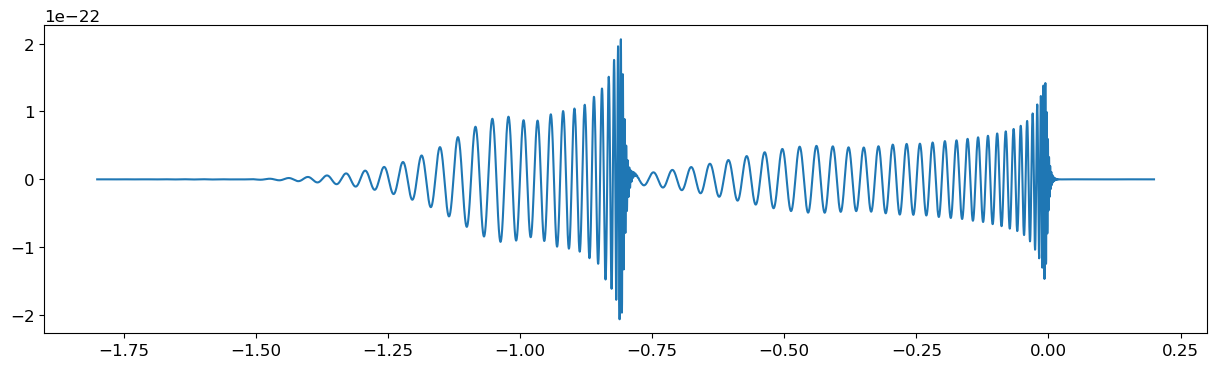

In [184]:
h1_bns = gen_waveform('IMRPhenomPv2',20,30,0.8,0.8,3000,0.0,"BNS")
h1_bbh = gen_waveform('IMRPhenomPv2',30,40,0.8,0.8,3000,0.0,"BBH")
ht_total,h1_bbh = overlap(h1_bns,h1_bbh,5.)
pp.figure(figsize=(15,4))
ht_total.plot()
pp.show()

# Creating Data

### Noise generation followed by creating 2 signals i.e. BNS and BBH; overlapping them in such a way that their merger peaks differ by 5 seconds,followed by injection of this overlapped signal into noise.Creating a template bank and calculating psd for this data(strain+noise)


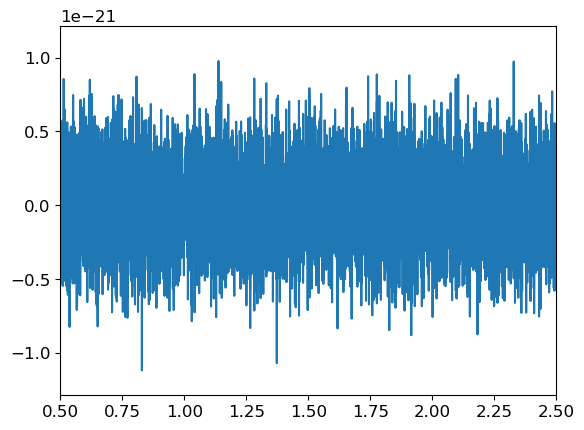

In [166]:
noise = gen_noise(False)

h1_bns = gen_waveform('IMRPhenomPv2',20,30,0.8,0.8,5000,0.0,"BNS")
h1_bbh = gen_waveform('IMRPhenomPv2',30,40,0.8,0.8,5000,0.0,"BBH")
ht_total,h1_bbh = overlap(h1_bns,h1_bbh,0.1)
ts1 = inject(ht_total,noise)

bns_templates = template_bank(20,30,10,3)
bbh_templates = template_bank(30,40,10,3)

psd1 = psd_data(ts1)

pp.plot(ts1.sample_times,ts1)
pp.xlim(0.5,2.5)
pp.show()

# Initiating the recovery process

In [179]:
tog = -1
mass_1,mass_2,time,snrp,total,j_snrp,tog = recovery(ts1,3,bns_templates,bbh_templates,psd1,tog)

for i in range(6):
    sub,psd_sub = align_sub(mass_1,mass_2,time,j_snrp,ts1,psd1)
    M1,M2,T,SP,Tot,k_snrp,tog = recovery(sub,3,bns_templates,bbh_templates,psd_sub,tog)
    # pp.plot(sub.sample_times,sub)
    # pp.xlim(0.5,1.5)
    # pp.show()
    mass_1=M1
    mass_2=M2
    time=T
    snrp=SP
    j_snrp = k_snrp
    total.extend([[0,0,0,0,0,0]])
    total.extend(Tot)

(35.4, 34.6); at 1.8000 secs; newSNR: 7.1436 chisq: 1.5768
                                                                  (20.0, 30.0); at 1.8999 secs; newSNR: 6.2103 chisq: 1.0520
(30.8, 45.2); at 1.7991 secs; newSNR: 7.5579 chisq: 1.0148
                                                                  (20.0, 30.0); at 1.8999 secs; newSNR: 6.9251 chisq: 1.0086
(30.8, 45.2); at 1.7991 secs; newSNR: 7.5722 chisq: 0.9848
                                                                  (20.0, 30.0); at 1.8999 secs; newSNR: 6.9448 chisq: 1.0055
(30.8, 45.2); at 1.7991 secs; newSNR: 7.5721 chisq: 0.9845
                                                                  (20.0, 30.0); at 1.8999 secs; newSNR: 6.9452 chisq: 1.0055
(30.8, 45.2); at 1.7991 secs; newSNR: 7.5721 chisq: 0.9845
                                                                  (20.0, 30.0); at 1.8999 secs; newSNR: 6.9452 chisq: 1.0055
(30.8, 45.2); at 1.7991 secs; newSNR: 7.5721 chisq: 0.9845


In [ ]:
for i in total:
    print(i)

### Storing the values of every iteration to an excel file

In [ ]:
df_total_info = pd.DataFrame(total,columns = ['M1','M2','Time','Old_SNR','New_SNR','Chi-Sq.','Complex snrp'])

df_total_info.to_excel('Iterative_Signal_Recovery.xlsx',index = False)